In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
from matplotlib.colors import LogNorm
import datetime
from astropy import units as u
import scopesim as sim
import scopesim_templates as sim_tp
import astropy.units as u

In [2]:
src = sim_tp.micado.cluster()

# Shift the source in the opposite direction of the dither we want to simulate.
shift_x = (1 * u.arcsec).to(u.degree)
shift_y = (2 * u.arcsec).to(u.degree)
src.shift(-shift_x, -shift_y)

INFO - sample_imf: Setting maximum allowed mass to 10000
INFO - sample_imf: Loop 0 added 1.01e+04 Msun to previous total of 0.00e+00 Msun


In [3]:
cmd = sim.UserCommands(
    use_instrument="MICADO",
    set_modes=["SCAO", "IMG_4mas"],
)
cmd.update(properties={
    "!OBS.filter_name_fw1": "open", 
    "!OBS.filter_name_fw2": "H", 
    "!OBS.ndit": 1, 
    "!OBS.dit": 3600,

    "!OBS.catg": "SCIENCE",
    "!OBS.tech": "IMAGE",
    "!OBS.type": "OBJECT",
    "!OBS.mjdobs": datetime.datetime(2022, 1, 1, 2, 30, 0),
    
    # Fake dithering.
    "!OBS.ra": shift_x,
    "!OBS.dec": shift_y,
    "!OBS.tplexpno": 2,
})

cmd["!DET.width"] = 4096     # pixel
cmd["!DET.height"] = 4096

micado = sim.OpticalTrain(cmd)
micado["MICADO_DET"]["detector_window"].include = False
micado["MICADO_DET"]["full_detector_array"].include = True
micado.observe(src)
hdus = micado.readout()

In [4]:
len(hdus[0])

10

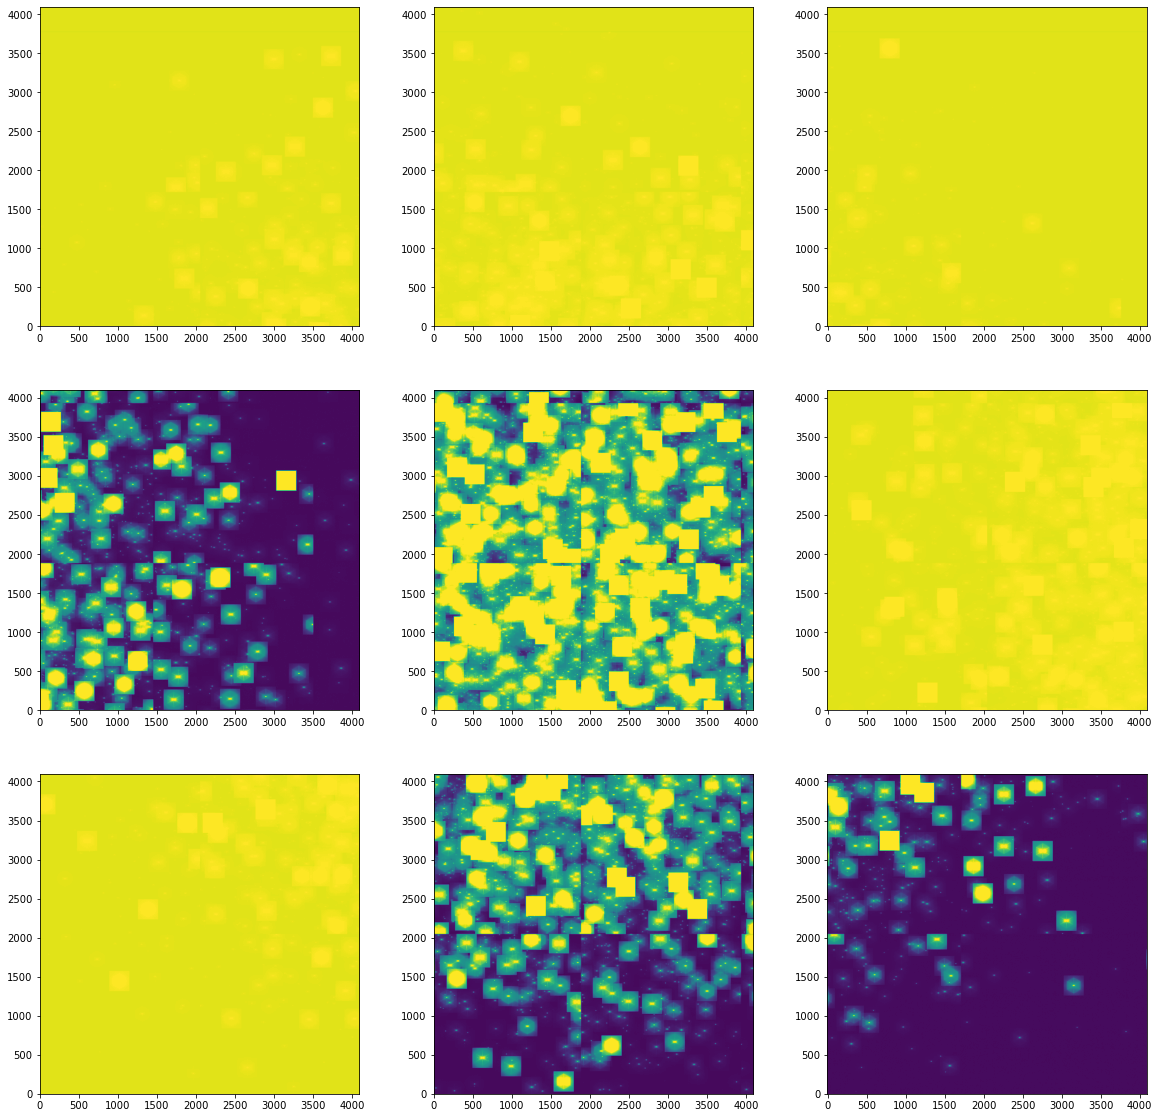

In [5]:
plt.figure(figsize=(20, 20))
for i in range(1, 10):
    plt.subplot(3, 3, i)
    plt.imshow(hdus[0][i].data, origin="lower", norm=LogNorm())

In [6]:
hdus[0][0].header

SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                    8 / array data type                                
NAXIS   =                    0 / number of array dimensions                     
EXTEND  =                    T                                                  
MJD-OBS = '2022-01-01T02:30:00'                                                 
RA      = 0.000277777777777777 / [deg]                                          
DEC     = 0.000555555555555555 / [deg]                                          
HIERARCH ESO DPR CATG = 'SCIENCE '                                              
HIERARCH ESO DPR TYPE = 'OBJECT  '                                              
HIERARCH ESO DPR TECH = 'IMAGE   '                                              
HIERARCH ESO DET DIT = 3600                                                     
HIERARCH ESO DET NDIT = 1                                                       
HIERARCH ESO DET READOUT = '

In [7]:
hdus[0].writeto("my_dithered_cluster.fits", overwrite=True)